# Step.0 Prepare

In [15]:
# 1. Load speaker embedding
import glob
import numpy as np
from scipy import spatial
import pickle

embds_dict={}
for npy_path in glob.glob('./DRL-TU/egs/exp/time_varying_all_T_epoch21_rank*.npy'):
    print(npy_path)
    embds_dict_tmp = np.load(npy_path,allow_pickle=True).item()
    embds_dict ={**embds_dict,**embds_dict_tmp}

./DRL-TU/egs/exp/time_varying_all_T_epoch21_rank0.npy
./DRL-TU/egs/exp/time_varying_all_T_epoch21_rank1.npy
./DRL-TU/egs/exp/time_varying_all_T_epoch21_rank2.npy


# Step.1 Inference

In [16]:
from collections import defaultdict
from utils.util import compute_eer
from tqdm import tqdm
embd_size=128
scenario2model2day2score_v0=defaultdict(list)
scenario2model2day2score_v1=defaultdict(list)
scenario2model2day2score_v21=defaultdict(list)
scenario2model2day2score_v22=defaultdict(list)

## Baseline Method  Scoring ( V0 )

In [17]:
eers_v0={}
mindcts_v0={}

for tmp_scenario in tqdm(['random','1das','3das','5das','10das','1d1s','3d1s','5d1s','10d1s']):
    # 0. init
    scenario2model2day2score_v0[tmp_scenario]=defaultdict(list)
    
    # 1. Load trial trajectory and enrollment model
    f_read = open('./trials/%s/trial.pkl' %tmp_scenario, 'rb')
    trials = pickle.load(f_read)
    f_read.close()
    enrol_models={i.split()[0]:i.split()[1:] for i in open('./trials/%s/enrol_model'%tmp_scenario)}
    
    # 2. achieve enrol template
    enrol_embd_dict={}
    for tmp_model in enrol_models:
        enrol_embd=np.zeros((1,128))
        for utt in enrol_models[tmp_model]:
            enrol_embd += embds_dict[utt]

        enrol_embd_dict[tmp_model]=enrol_embd/np.linalg.norm(enrol_embd)
    # 3. scoring
    true_score=[]
    false_score=[]
    
    if tmp_scenario in ['random']:
        for tmp_model in trials:
            ts=tmp_model[3:7]
            scenario2model2day2score_v0[tmp_scenario][tmp_model]=defaultdict(list)
            for utt in trials[tmp_model]:
                test_embd = embds_dict[utt]
                result = 1 - spatial.distance.cosine(enrol_embd_dict[tmp_model], test_embd)
                if ts == utt[:4]:
                    true_score.append(result) 
                    scenario2model2day2score_v0[tmp_scenario][tmp_model]['true'].append(result)
                else:
                    false_score.append(result) 
                    scenario2model2day2score_v0[tmp_scenario][tmp_model]['false'].append(result)
    elif tmp_scenario in ['1das','3das','5das','10das']:
        for tmp_model in trials:
            ts=tmp_model[3:7]
            scenario2model2day2score_v0[tmp_scenario][tmp_model]=defaultdict(list)
            for day in trials[tmp_model]:
                scenario2model2day2score_v0[tmp_scenario][tmp_model][day]=defaultdict(list)
                for utt in trials[tmp_model][day]:
                    test_embd = embds_dict[utt]
                    result = 1 - spatial.distance.cosine(enrol_embd_dict[tmp_model], test_embd)
                    if ts == utt[:4]:
                        true_score.append(result) 
                        scenario2model2day2score_v0[tmp_scenario][tmp_model][day]['true'].append(result)
                    else:
                        false_score.append(result) 
                        scenario2model2day2score_v0[tmp_scenario][tmp_model][day]['false'].append(result)
    elif tmp_scenario in ['1d1s','3d1s','5d1s','10d1s']:
        for tmp_round in trials:
            scenario2model2day2score_v0[tmp_scenario][tmp_round]=defaultdict(list)
            for tmp_model in trials[tmp_round]:
                ts=tmp_model[3:7]
                scenario2model2day2score_v0[tmp_scenario][tmp_round][tmp_model]=defaultdict(list)
                for day in trials[tmp_round][tmp_model]:
                    scenario2model2day2score_v0[tmp_scenario][tmp_round][tmp_model][day]=defaultdict(list)
                    for utt in trials[tmp_round][tmp_model][day]:
                        test_embd = embds_dict[utt]
                        result = 1 - spatial.distance.cosine(enrol_embd_dict[tmp_model], test_embd)
                        if ts == utt[:4]:
                            true_score.append(result) 
                            scenario2model2day2score_v0[tmp_scenario][tmp_round][tmp_model][day]['true'].append(result)
                        else:
                            false_score.append(result) 
                            scenario2model2day2score_v0[tmp_scenario][tmp_round][tmp_model][day]['false'].append(result)

    eer_v0, threshold_eer, mindct_v0, threashold_dct = compute_eer(np.array(true_score), np.array(false_score))
    eers_v0[tmp_scenario]=eer_v0
    mindcts_v0[tmp_scenario]=mindct_v0
    print('---- Scenario : %s----'%tmp_scenario)
    print('EER: %s, EER_threshold: %s \nMinDCT: %s, MinDCT_threshold: %s, '%(eer_v0*100,threshold_eer, mindct_v0, threashold_dct))
    print(len(true_score),len(false_score))
    

  0%|                                                                         | 0/9 [00:00<?, ?it/s]/tmp/ipykernel_35769/637914665.py:21: RuntimeWarning: invalid value encountered in divide
  enrol_embd_dict[tmp_model]=enrol_embd/np.linalg.norm(enrol_embd)
 11%|███████▏                                                         | 1/9 [00:07<00:58,  7.34s/it]

---- Scenario : random----
EER: 3.741261927387755, EER_threshold: 0.4204883810721398 
MinDCT: 0.4168760332730183, MinDCT_threshold: 0.6114183805549603, 
76819 76819


 22%|██████████████▍                                                  | 2/9 [00:14<00:49,  7.06s/it]

---- Scenario : 1das----
EER: 3.5488372699646553, EER_threshold: 0.42262014935163994 
MinDCT: 0.4114094922593351, MinDCT_threshold: 0.6101848045173396, 
76673 76673


 33%|█████████████████████▋                                           | 3/9 [00:21<00:43,  7.26s/it]

---- Scenario : 3das----
EER: 3.1537940379403793, EER_threshold: 0.43440902365005996 
MinDCT: 0.38472222222222224, MinDCT_threshold: 0.6166655118717964, 
88560 88560


 44%|████████████████████████████▉                                    | 4/9 [00:27<00:33,  6.62s/it]

---- Scenario : 5das----
EER: 3.106192677935269, EER_threshold: 0.43856202796563903 
MinDCT: 0.3766239672553627, MinDCT_threshold: 0.6300347089493383, 
65965 65965


 56%|████████████████████████████████████                             | 5/9 [00:32<00:24,  6.07s/it]

---- Scenario : 10das----
EER: 3.1131727903004323, EER_threshold: 0.4379431343961363 
MinDCT: 0.38520280001339724, MinDCT_threshold: 0.6207601899579509, 
59714 59714


 67%|███████████████████████████████████████████▎                     | 6/9 [00:40<00:20,  6.72s/it]

---- Scenario : 1d1s----
EER: 3.608339728830903, EER_threshold: 0.4210491813310211 
MinDCT: 0.40076745970836525, MinDCT_threshold: 0.6056797494933029, 
78180 78180


 78%|██████████████████████████████████████████████████▌              | 7/9 [00:48<00:14,  7.20s/it]

---- Scenario : 3d1s----
EER: 3.214285714285714, EER_threshold: 0.43185900051725 
MinDCT: 0.38895053166897825, MinDCT_threshold: 0.622124760633776, 
86520 86520


 89%|█████████████████████████████████████████████████████████▊       | 8/9 [00:54<00:06,  6.91s/it]

---- Scenario : 5d1s----
EER: 3.1555971312753353, EER_threshold: 0.4349993243156891 
MinDCT: 0.4003429996881821, MinDCT_threshold: 0.6009552607194296, 
64140 64140


100%|█████████████████████████████████████████████████████████████████| 9/9 [01:00<00:00,  6.75s/it]

---- Scenario : 10d1s----
EER: 3.0926594464500603, EER_threshold: 0.43475103455404407 
MinDCT: 0.3838748495788207, MinDCT_threshold: 0.6196905461999074, 
58170 58170


## FixW-TU  Scoring ( V1 )

In [18]:
eers_v1=defaultdict(list)
mindcts_v1=defaultdict(list)
Threshold=0.51

for alpha in [0.05,0.1,0.15,0.2,0.3,0.4,0.5]:
    scenario2model2day2score_v1[alpha]=defaultdict(list)
    eers_v1[alpha]={}
    mindcts_v1[alpha]={}
    for tmp_scenario in tqdm(['random','1das','3das','5das','10das','1d1s','3d1s','5d1s','10d1s']):
        # 0. init
        scenario2model2day2score_v1[alpha][tmp_scenario]=defaultdict(list)

        # 1. Load trial trajectory and enrollment model
        f_read = open('./trials/%s/trial.pkl' %tmp_scenario, 'rb')
        trials = pickle.load(f_read)
        f_read.close()
        enrol_models={i.split()[0]:i.split()[1:] for i in open('./trials/%s/enrol_model'%tmp_scenario)}

        # 2. achieve enrol template
        enrol_embd_dict={}
        for tmp_model in enrol_models:
            enrol_embd=np.zeros((1,128))
            for utt in enrol_models[tmp_model]:
                enrol_embd += embds_dict[utt]

#             enrol_embd_dict[tmp_model]=enrol_embd/np.linalg.norm(enrol_embd)
            enrol_embd_dict[tmp_model]=enrol_embd
        # 3. scoring
        true_score=[]
        false_score=[]

        if tmp_scenario in ['random']:
            for tmp_model in trials:
                ts=tmp_model[3:7]
                scenario2model2day2score_v1[alpha][tmp_scenario][tmp_model]=defaultdict(list)
                for utt in trials[tmp_model]:
                    test_embd = embds_dict[utt]
                    result = 1 - spatial.distance.cosine(enrol_embd_dict[tmp_model], test_embd)
                    if ts == utt[:4]:
                        true_score.append(result) 
                        scenario2model2day2score_v1[alpha][tmp_scenario][tmp_model]['true'].append(result)
                    else:
                        false_score.append(result) 
                        scenario2model2day2score_v1[alpha][tmp_scenario][tmp_model]['false'].append(result)
                    
                    if result> Threshold:
                        enrol_model = (1-alpha)*enrol_embd_dict[tmp_model] + alpha*test_embd
                        enrol_embd_dict[tmp_model] = enrol_model
                    
        elif tmp_scenario in ['1das','3das','5das','10das']:
            for tmp_model in trials:
                ts=tmp_model[3:7]
                scenario2model2day2score_v1[alpha][tmp_scenario][tmp_model]=defaultdict(list)
                for day in trials[tmp_model]:
                    scenario2model2day2score_v1[alpha][tmp_scenario][tmp_model][day]=defaultdict(list)
                    for utt in trials[tmp_model][day]:
                        test_embd = embds_dict[utt]
                        result = 1 - spatial.distance.cosine(enrol_embd_dict[tmp_model], test_embd)
                        if ts == utt[:4]:
                            true_score.append(result) 
                            scenario2model2day2score_v1[alpha][tmp_scenario][tmp_model][day]['true'].append(result)
                        else:
                            false_score.append(result) 
                            scenario2model2day2score_v1[alpha][tmp_scenario][tmp_model][day]['false'].append(result)
                        
                        if result> Threshold:
                            enrol_model = (1-alpha)*enrol_embd_dict[tmp_model] + alpha*test_embd
                            enrol_embd_dict[tmp_model] = enrol_model
                        
        elif tmp_scenario in ['1d1s','3d1s','5d1s','10d1s']:
            for tmp_round in trials:
                scenario2model2day2score_v1[alpha][tmp_scenario][tmp_round]=defaultdict(list)
                for tmp_model in trials[tmp_round]:
                    ts=tmp_model[3:7]
                    scenario2model2day2score_v1[alpha][tmp_scenario][tmp_round][tmp_model]=defaultdict(list)
                    for day in trials[tmp_round][tmp_model]:
                        scenario2model2day2score_v1[alpha][tmp_scenario][tmp_round][tmp_model][day]=defaultdict(list)
                        for utt in trials[tmp_round][tmp_model][day]:
                            test_embd = embds_dict[utt]
                            result = 1 - spatial.distance.cosine(enrol_embd_dict[tmp_model], test_embd)
                            if ts == utt[:4]:
                                true_score.append(result) 
                                scenario2model2day2score_v1[alpha][tmp_scenario][tmp_round][tmp_model][day]['true'].append(result)
                            else:
                                false_score.append(result) 
                                scenario2model2day2score_v1[alpha][tmp_scenario][tmp_round][tmp_model][day]['false'].append(result)
                            
                            if result> Threshold:
                                enrol_model = (1-alpha)*enrol_embd_dict[tmp_model] + alpha*test_embd
                                enrol_embd_dict[tmp_model] = enrol_model
                                
        eer_v1, threshold_eer, mindct_v1, threashold_dct = compute_eer(np.array(true_score), np.array(false_score))
        eers_v1[alpha][tmp_scenario]=eer_v1
        mindcts_v1[alpha][tmp_scenario]=mindct_v1

        print('---- Alpha: %s, Scenario : %s----'%(alpha,tmp_scenario))
        print('EER: %s, EER_threshold: %s \nMinDCT: %s, MinDCT_threshold: %s, '%(eer_v1*100,threshold_eer, mindct_v1, threashold_dct))
        print(len(true_score),len(false_score))
    

 11%|███████▏                                                         | 1/9 [00:07<01:00,  7.61s/it]

---- Alpha: 0.05, Scenario : random----
EER: 3.064346060219477, EER_threshold: 0.44583582648185094 
MinDCT: 0.3554719535531574, MinDCT_threshold: 0.6383059435130687, 
76819 76819


 22%|██████████████▍                                                  | 2/9 [00:14<00:52,  7.44s/it]

---- Alpha: 0.05, Scenario : 1das----
EER: 1.1685991157252227, EER_threshold: 0.5211724994979267 
MinDCT: 0.23686304174872513, MinDCT_threshold: 0.6626917801236984, 
76673 76673


 33%|█████████████████████▋                                           | 3/9 [00:23<00:47,  7.86s/it]

---- Alpha: 0.05, Scenario : 3das----
EER: 1.5311653116531165, EER_threshold: 0.5037094774929685 
MinDCT: 0.22057362240289066, MinDCT_threshold: 0.6549831042549724, 
88560 88560


 44%|████████████████████████████▉                                    | 4/9 [00:29<00:36,  7.22s/it]

---- Alpha: 0.05, Scenario : 5das----
EER: 1.609944667626772, EER_threshold: 0.49824611765427607 
MinDCT: 0.2530129614189343, MinDCT_threshold: 0.6531114679451092, 
65965 65965


 56%|████████████████████████████████████                             | 5/9 [00:35<00:26,  6.66s/it]

---- Alpha: 0.05, Scenario : 10das----
EER: 2.128479083631979, EER_threshold: 0.47831210505443345 
MinDCT: 0.30098469370666847, MinDCT_threshold: 0.6521729795247512, 
59714 59714


 67%|███████████████████████████████████████████▎                     | 6/9 [00:43<00:21,  7.14s/it]

---- Alpha: 0.05, Scenario : 1d1s----
EER: 1.6193399846508059, EER_threshold: 0.504464766407361 
MinDCT: 0.26662829368124835, MinDCT_threshold: 0.6547631808683904, 
78180 78180


 78%|██████████████████████████████████████████████████▌              | 7/9 [00:52<00:15,  7.77s/it]

---- Alpha: 0.05, Scenario : 3d1s----
EER: 1.7383263985205732, EER_threshold: 0.4947929149157759 
MinDCT: 0.2870550161812298, MinDCT_threshold: 0.643785233783581, 
86520 86520


 89%|█████████████████████████████████████████████████████████▊       | 8/9 [00:59<00:07,  7.46s/it]

---- Alpha: 0.05, Scenario : 5d1s----
EER: 1.9223573433115062, EER_threshold: 0.4879140902691219 
MinDCT: 0.29402868724664794, MinDCT_threshold: 0.65364466696043, 
64140 64140


100%|█████████████████████████████████████████████████████████████████| 9/9 [01:04<00:00,  7.22s/it]


---- Alpha: 0.05, Scenario : 10d1s----
EER: 2.2399862472064638, EER_threshold: 0.4741158190691941 
MinDCT: 0.3113116726835138, MinDCT_threshold: 0.6416539134572329, 
58170 58170


 11%|███████▏                                                         | 1/9 [00:07<00:58,  7.35s/it]

---- Alpha: 0.1, Scenario : random----
EER: 2.4785534828623126, EER_threshold: 0.46719423600342913 
MinDCT: 0.3142581913328734, MinDCT_threshold: 0.6538125762309162, 
76819 76819


 22%|██████████████▍                                                  | 2/9 [00:14<00:51,  7.37s/it]

---- Alpha: 0.1, Scenario : 1das----
EER: 1.1581651950491048, EER_threshold: 0.5194513746715624 
MinDCT: 0.23202431103517535, MinDCT_threshold: 0.6655423409516492, 
76673 76673


 33%|█████████████████████▋                                           | 3/9 [00:23<00:47,  7.90s/it]

---- Alpha: 0.1, Scenario : 3das----
EER: 1.4261517615176151, EER_threshold: 0.5057453735109346 
MinDCT: 0.20073396567299007, MinDCT_threshold: 0.6558726943581369, 
88560 88560


 44%|████████████████████████████▉                                    | 4/9 [00:29<00:36,  7.27s/it]

---- Alpha: 0.1, Scenario : 5das----
EER: 1.4022587735920564, EER_threshold: 0.5059456618872256 
MinDCT: 0.22630182672629426, MinDCT_threshold: 0.6644930677817602, 
65965 65965


 56%|████████████████████████████████████                             | 5/9 [00:35<00:26,  6.73s/it]

---- Alpha: 0.1, Scenario : 10das----
EER: 1.6997688984157817, EER_threshold: 0.4949006751177589 
MinDCT: 0.2758984492748769, MinDCT_threshold: 0.6549846217634249, 
59714 59714


 67%|███████████████████████████████████████████▎                     | 6/9 [00:43<00:21,  7.29s/it]

---- Alpha: 0.1, Scenario : 1d1s----
EER: 1.627014581734459, EER_threshold: 0.5022131392052704 
MinDCT: 0.27183422870299306, MinDCT_threshold: 0.6545716586880881, 
78180 78180


 78%|██████████████████████████████████████████████████▌              | 7/9 [00:52<00:15,  7.88s/it]

---- Alpha: 0.1, Scenario : 3d1s----
EER: 1.6805362921867777, EER_threshold: 0.4962670612073007 
MinDCT: 0.29366620434581603, MinDCT_threshold: 0.6530388796726543, 
86520 86520


 89%|█████████████████████████████████████████████████████████▊       | 8/9 [00:59<00:07,  7.42s/it]

---- Alpha: 0.1, Scenario : 5d1s----
EER: 1.7539756782039289, EER_threshold: 0.49296736601782365 
MinDCT: 0.28964764577486746, MinDCT_threshold: 0.6569263239445339, 
64140 64140


100%|█████████████████████████████████████████████████████████████████| 9/9 [01:05<00:00,  7.23s/it]


---- Alpha: 0.1, Scenario : 10d1s----
EER: 2.013065153859378, EER_threshold: 0.4824730847625527 
MinDCT: 0.2966993295513151, MinDCT_threshold: 0.6493027363741095, 
58170 58170


 11%|███████▏                                                         | 1/9 [00:08<01:05,  8.17s/it]

---- Alpha: 0.15, Scenario : random----
EER: 2.190864239315794, EER_threshold: 0.4763895845014845 
MinDCT: 0.3074499798227001, MinDCT_threshold: 0.6524161831737595, 
76819 76819


 22%|██████████████▍                                                  | 2/9 [00:15<00:53,  7.67s/it]

---- Alpha: 0.15, Scenario : 1das----
EER: 1.237723840204505, EER_threshold: 0.5134037003419971 
MinDCT: 0.2286984988196627, MinDCT_threshold: 0.6564822826659105, 
76673 76673


 33%|█████████████████████▋                                           | 3/9 [00:24<00:48,  8.10s/it]

---- Alpha: 0.15, Scenario : 3das----
EER: 1.4442186088527553, EER_threshold: 0.5017089506505166 
MinDCT: 0.19620596205962057, MinDCT_threshold: 0.6520116135231667, 
88560 88560


 44%|████████████████████████████▉                                    | 4/9 [00:30<00:36,  7.39s/it]

---- Alpha: 0.15, Scenario : 5das----
EER: 1.3552641552338363, EER_threshold: 0.5044515589161146 
MinDCT: 0.22419464867732886, MinDCT_threshold: 0.6681353423017514, 
65965 65965


 56%|████████████████████████████████████                             | 5/9 [00:36<00:27,  6.77s/it]

---- Alpha: 0.15, Scenario : 10das----
EER: 1.6177110895267441, EER_threshold: 0.4968937021158908 
MinDCT: 0.25422848913152696, MinDCT_threshold: 0.6557229559179498, 
59714 59714


 67%|███████████████████████████████████████████▎                     | 6/9 [00:44<00:22,  7.39s/it]

---- Alpha: 0.15, Scenario : 1d1s----
EER: 1.6935277564594526, EER_threshold: 0.49763909809563256 
MinDCT: 0.2793681248401126, MinDCT_threshold: 0.6418944034306, 
78180 78180


 78%|██████████████████████████████████████████████████▌              | 7/9 [00:53<00:15,  7.88s/it]

---- Alpha: 0.15, Scenario : 3d1s----
EER: 1.7475728155339807, EER_threshold: 0.49362411891344515 
MinDCT: 0.2986245954692557, MinDCT_threshold: 0.6525041779593673, 
86520 86520


 89%|█████████████████████████████████████████████████████████▊       | 8/9 [01:00<00:07,  7.72s/it]

---- Alpha: 0.15, Scenario : 5d1s----
EER: 1.816339257873402, EER_threshold: 0.4897718524877459 
MinDCT: 0.29554100405363265, MinDCT_threshold: 0.6480698818917934, 
64140 64140


100%|█████████████████████████████████████████████████████████████████| 9/9 [01:06<00:00,  7.43s/it]


---- Alpha: 0.15, Scenario : 10d1s----
EER: 1.9993123603231906, EER_threshold: 0.48296752782039665 
MinDCT: 0.2985043837029397, MinDCT_threshold: 0.6319495010935431, 
58170 58170


 11%|███████▏                                                         | 1/9 [00:07<00:59,  7.40s/it]

---- Alpha: 0.2, Scenario : random----
EER: 2.0906286205235682, EER_threshold: 0.47861225479798 
MinDCT: 0.30711152188911595, MinDCT_threshold: 0.6488880488951463, 
76819 76819


 22%|██████████████▍                                                  | 2/9 [00:14<00:52,  7.44s/it]

---- Alpha: 0.2, Scenario : 1das----
EER: 1.3303248862050527, EER_threshold: 0.5047283778584207 
MinDCT: 0.23074615575235088, MinDCT_threshold: 0.6542427036733757, 
76673 76673


 33%|█████████████████████▋                                           | 3/9 [00:23<00:47,  7.87s/it]

---- Alpha: 0.2, Scenario : 3das----
EER: 1.5006775067750677, EER_threshold: 0.4952896087734361 
MinDCT: 0.1931007226738934, MinDCT_threshold: 0.6430676918601229, 
88560 88560


 44%|████████████████████████████▉                                    | 4/9 [00:29<00:36,  7.26s/it]

---- Alpha: 0.2, Scenario : 5das----
EER: 1.423482149624801, EER_threshold: 0.49711622691810153 
MinDCT: 0.21976805881907072, MinDCT_threshold: 0.643808000695535, 
65965 65965


 56%|████████████████████████████████████                             | 5/9 [00:35<00:26,  6.69s/it]

---- Alpha: 0.2, Scenario : 10das----
EER: 1.6277589844927487, EER_threshold: 0.4935915365602479 
MinDCT: 0.2498744013129249, MinDCT_threshold: 0.672779741071006, 
59714 59714


 67%|███████████████████████████████████████████▎                     | 6/9 [00:43<00:21,  7.09s/it]

---- Alpha: 0.2, Scenario : 1d1s----
EER: 1.7958557175748273, EER_threshold: 0.4924567545733254 
MinDCT: 0.2898567408544384, MinDCT_threshold: 0.6442521222547377, 
78180 78180


 78%|██████████████████████████████████████████████████▌              | 7/9 [00:52<00:15,  7.98s/it]

---- Alpha: 0.2, Scenario : 3d1s----
EER: 1.833102172907998, EER_threshold: 0.488022849535074 
MinDCT: 0.3033633841886269, MinDCT_threshold: 0.6465314635363562, 
86520 86520


 89%|█████████████████████████████████████████████████████████▊       | 8/9 [00:59<00:07,  7.53s/it]

---- Alpha: 0.2, Scenario : 5d1s----
EER: 1.8896164639850328, EER_threshold: 0.4860815635418454 
MinDCT: 0.3055971312753352, MinDCT_threshold: 0.6422249201099174, 
64140 64140


100%|█████████████████████████████████████████████████████████████████| 9/9 [01:05<00:00,  7.26s/it]


---- Alpha: 0.2, Scenario : 10d1s----
EER: 2.033694344163658, EER_threshold: 0.4806524763282436 
MinDCT: 0.3064638129620079, MinDCT_threshold: 0.6412885744412963, 
58170 58170


 11%|███████▏                                                         | 1/9 [00:07<00:59,  7.47s/it]

---- Alpha: 0.3, Scenario : random----
EER: 2.133586742863094, EER_threshold: 0.47353382758777807 
MinDCT: 0.3134510993374035, MinDCT_threshold: 0.6386480127272544, 
76819 76819


 22%|██████████████▍                                                  | 2/9 [00:15<00:52,  7.54s/it]

---- Alpha: 0.3, Scenario : 1das----
EER: 1.5676965815867385, EER_threshold: 0.4868457909828581 
MinDCT: 0.2319851838326399, MinDCT_threshold: 0.6365848646871476, 
76673 76673


 33%|█████████████████████▋                                           | 3/9 [00:23<00:48,  8.09s/it]

---- Alpha: 0.3, Scenario : 3das----
EER: 1.7841011743450768, EER_threshold: 0.4802845633475106 
MinDCT: 0.2088075880758808, MinDCT_threshold: 0.63848602801106, 
88560 88560


 44%|████████████████████████████▉                                    | 4/9 [00:30<00:37,  7.45s/it]

---- Alpha: 0.3, Scenario : 5das----
EER: 1.6493595088304405, EER_threshold: 0.4822860699829272 
MinDCT: 0.2155991813840673, MinDCT_threshold: 0.6626279405900707, 
65965 65965


 56%|████████████████████████████████████                             | 5/9 [00:36<00:27,  6.84s/it]

---- Alpha: 0.3, Scenario : 10das----
EER: 1.7433097766018018, EER_threshold: 0.48208482464805114 
MinDCT: 0.23684563084033894, MinDCT_threshold: 0.6625763318284964, 
59714 59714


 67%|███████████████████████████████████████████▎                     | 6/9 [00:43<00:21,  7.19s/it]

---- Alpha: 0.3, Scenario : 1d1s----
EER: 1.9813251470964441, EER_threshold: 0.47956447777084665 
MinDCT: 0.3122026093630085, MinDCT_threshold: 0.63336180351067, 
78180 78180


 78%|██████████████████████████████████████████████████▌              | 7/9 [00:53<00:16,  8.05s/it]

---- Alpha: 0.3, Scenario : 3d1s----
EER: 2.0434581599630146, EER_threshold: 0.474919564390897 
MinDCT: 0.3253698566805363, MinDCT_threshold: 0.636553169019357, 
86520 86520


 89%|█████████████████████████████████████████████████████████▊       | 8/9 [01:00<00:07,  7.55s/it]

---- Alpha: 0.3, Scenario : 5d1s----
EER: 2.0985344558777674, EER_threshold: 0.4731462298127498 
MinDCT: 0.3334112878079202, MinDCT_threshold: 0.6461586565045327, 
64140 64140


100%|█████████████████████████████████████████████████████████████████| 9/9 [01:06<00:00,  7.35s/it]


---- Alpha: 0.3, Scenario : 10d1s----
EER: 2.1729413787175518, EER_threshold: 0.47259668557608636 
MinDCT: 0.32784940691077874, MinDCT_threshold: 0.6299571982327189, 
58170 58170


 11%|███████▏                                                         | 1/9 [00:07<00:58,  7.35s/it]

---- Alpha: 0.4, Scenario : random----
EER: 2.397844283315326, EER_threshold: 0.4616756936178412 
MinDCT: 0.33685676720602975, MinDCT_threshold: 0.6353634468037016, 
76819 76819


 22%|██████████████▍                                                  | 2/9 [00:14<00:52,  7.44s/it]

---- Alpha: 0.4, Scenario : 1das----
EER: 2.296766788830488, EER_threshold: 0.45805204043399783 
MinDCT: 0.2524747955603668, MinDCT_threshold: 0.6355663280966231, 
76673 76673


 33%|█████████████████████▋                                           | 3/9 [00:23<00:47,  7.91s/it]

---- Alpha: 0.4, Scenario : 3das----
EER: 2.261743450767841, EER_threshold: 0.4574016663009448 
MinDCT: 0.22964092140921413, MinDCT_threshold: 0.655202010347544, 
88560 88560


 44%|████████████████████████████▉                                    | 4/9 [00:29<00:36,  7.27s/it]

---- Alpha: 0.4, Scenario : 5das----
EER: 2.0935344500871675, EER_threshold: 0.4630455819897443 
MinDCT: 0.2301523535208065, MinDCT_threshold: 0.6553941472234484, 
65965 65965


 56%|████████████████████████████████████                             | 5/9 [00:35<00:26,  6.66s/it]

---- Alpha: 0.4, Scenario : 10das----
EER: 2.1351776802759823, EER_threshold: 0.46296816987541933 
MinDCT: 0.2469102722979536, MinDCT_threshold: 0.6386815911588218, 
59714 59714


 67%|███████████████████████████████████████████▎                     | 6/9 [00:43<00:21,  7.08s/it]

---- Alpha: 0.4, Scenario : 1d1s----
EER: 2.2115630596060374, EER_threshold: 0.4658447207443003 
MinDCT: 0.3325402916346892, MinDCT_threshold: 0.6153869410974041, 
78180 78180


 78%|██████████████████████████████████████████████████▌              | 7/9 [00:51<00:15,  7.66s/it]

---- Alpha: 0.4, Scenario : 3d1s----
EER: 2.300046232085067, EER_threshold: 0.46045675871008884 
MinDCT: 0.34958391123439664, MinDCT_threshold: 0.6290245493262936, 
86520 86520


 89%|█████████████████████████████████████████████████████████▊       | 8/9 [00:59<00:07,  7.67s/it]

---- Alpha: 0.4, Scenario : 5d1s----
EER: 2.360461490489554, EER_threshold: 0.46075522625036114 
MinDCT: 0.3600405363267852, MinDCT_threshold: 0.6375136214165464, 
64140 64140


100%|█████████████████████████████████████████████████████████████████| 9/9 [01:05<00:00,  7.29s/it]


---- Alpha: 0.4, Scenario : 10d1s----
EER: 2.4050197696407083, EER_threshold: 0.4601473503320186 
MinDCT: 0.3573835310297404, MinDCT_threshold: 0.6402068402804447, 
58170 58170


 11%|███████▏                                                         | 1/9 [00:07<00:58,  7.32s/it]

---- Alpha: 0.5, Scenario : random----
EER: 2.7258881266353376, EER_threshold: 0.44736162750135455 
MinDCT: 0.35336310027467166, MinDCT_threshold: 0.6313428544526367, 
76819 76819


 22%|██████████████▍                                                  | 2/9 [00:14<00:51,  7.37s/it]

---- Alpha: 0.5, Scenario : 1das----
EER: 3.0623557184406507, EER_threshold: 0.4347335367590397 
MinDCT: 0.2765510675205092, MinDCT_threshold: 0.6295275981156513, 
76673 76673


 33%|█████████████████████▋                                           | 3/9 [00:23<00:48,  8.03s/it]

---- Alpha: 0.5, Scenario : 3das----
EER: 3.030713640469738, EER_threshold: 0.43418703876579 
MinDCT: 0.2513775971093044, MinDCT_threshold: 0.6364608607048166, 
88560 88560


 44%|████████████████████████████▉                                    | 4/9 [00:29<00:36,  7.33s/it]

---- Alpha: 0.5, Scenario : 5das----
EER: 2.7029485333131205, EER_threshold: 0.44366806657622915 
MinDCT: 0.2535738649283711, MinDCT_threshold: 0.6296999997398992, 
65965 65965


 56%|████████████████████████████████████                             | 5/9 [00:35<00:26,  6.72s/it]

---- Alpha: 0.5, Scenario : 10das----
EER: 2.654318920186221, EER_threshold: 0.4447074265158555 
MinDCT: 0.2553505040693974, MinDCT_threshold: 0.6349414368240394, 
59714 59714


 67%|███████████████████████████████████████████▎                     | 6/9 [00:43<00:21,  7.11s/it]

---- Alpha: 0.5, Scenario : 1d1s----
EER: 2.541570734203121, EER_threshold: 0.45099075539383593 
MinDCT: 0.36290611409567664, MinDCT_threshold: 0.6078769375298237, 
78180 78180


 78%|██████████████████████████████████████████████████▌              | 7/9 [00:52<00:15,  7.67s/it]

---- Alpha: 0.5, Scenario : 3d1s----
EER: 2.777392510402219, EER_threshold: 0.4442189610884293 
MinDCT: 0.3777045769764216, MinDCT_threshold: 0.6263129588106932, 
86520 86520


 89%|█████████████████████████████████████████████████████████▊       | 8/9 [00:58<00:07,  7.28s/it]

---- Alpha: 0.5, Scenario : 5d1s----
EER: 2.720611163080761, EER_threshold: 0.4466104178471677 
MinDCT: 0.3792017461802307, MinDCT_threshold: 0.621164300030476, 
64140 64140


100%|█████████████████████████████████████████████████████████████████| 9/9 [01:05<00:00,  7.32s/it]

---- Alpha: 0.5, Scenario : 10d1s----
EER: 2.680075640364449, EER_threshold: 0.4472871640622963 
MinDCT: 0.3735946364105209, MinDCT_threshold: 0.6105346292144689, 
58170 58170


## DRL-TU-AdW (V21)

In [19]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Pi_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Pi_net, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.mu = nn.Linear(int(hidden_size/2), output_size)
        self.sigma = nn.Linear(int(hidden_size/2), output_size)

    def forward(self, s):
        x = F.relu(self.linear1(s))
        x = F.relu(self.linear2(x))
        mu = (torch.tanh(self.mu(x))+1)/2
        sigma = F.softplus(self.mu(x))
        return mu,sigma 

actor = Pi_net(256, 256, 1) # 
checkpoint = torch.load('./DRL-TU/egs/exp/DRL-TU-AdW_pretrained/model_final.pkl',map_location='cpu')
actor.load_state_dict(checkpoint['pi'],strict=False)
actor = actor.to('cuda:3')

In [43]:
eers_v21={}
mindcts_v21={}
Threshold=0.51
visual=False

for tmp_scenario in tqdm(['random','1das','3das','5das','10das','1d1s','3d1s','5d1s','10d1s']):
# for tmp_scenario in tqdm(['random']):
    # 0. init
    scenario2model2day2score_v21[tmp_scenario]=defaultdict(list)
    
    # 1. Load trial trajectory and enrollment model
    f_read = open('./trials/%s/trial.pkl' %tmp_scenario, 'rb')
    trials = pickle.load(f_read)
    f_read.close()
    enrol_models={i.split()[0]:i.split()[1:] for i in open('./trials/%s/enrol_model'%tmp_scenario)}
    
    # 2. achieve enrol template
    enrol_embd_dict={}
    for tmp_model in enrol_models:
        enrol_embd=np.zeros((1,128))
        for utt in enrol_models[tmp_model]:
            enrol_embd += embds_dict[utt]

#         enrol_embd_dict[tmp_model]=enrol_embd/np.linalg.norm(enrol_embd)
        enrol_embd_dict[tmp_model]=enrol_embd/5
    # 3. scoring
    true_score=[]
    false_score=[]
    
    if tmp_scenario in ['random']:
        for tmp_model in trials:
            enrol_embd = enrol_embd_dict[tmp_model]
            ts=tmp_model[3:7]
            scenario2model2day2score_v21[tmp_scenario][tmp_model]=defaultdict(list)
            for utt in trials[tmp_model]:
                test_embd = embds_dict[utt]
                
                result = 1 - spatial.distance.cosine(enrol_embd, test_embd)
                
                if ts == utt[:4]:
                    true_score.append(result) 
                    scenario2model2day2score_v21[tmp_scenario][tmp_model]['true'].append(result)
                else:
                    false_score.append(result) 
                    scenario2model2day2score_v21[tmp_scenario][tmp_model]['false'].append(result)
                    
                if result> Threshold:
                    enrol_embd = enrol_embd/np.linalg.norm(enrol_embd)
                    test_embd = test_embd/np.linalg.norm(test_embd)
                    
                    observation = np.concatenate((enrol_embd,test_embd),axis=1)
                    observation = torch.from_numpy(observation.astype('float32'))
                    observation = observation.to('cuda:3')
                    mu,sigma = actor(observation)
                    action_value = mu
                    action_value = action_value.cpu().detach().cpu().numpy()[0][0]
                    if visual: print(utt,ts,result,action_value)
                    enrol_embd = (1-action_value)*enrol_embd + action_value*test_embd
                    
    elif tmp_scenario in ['1das','3das','5das','10das']:
        for tmp_model in trials:
            enrol_embd = enrol_embd_dict[tmp_model]
            ts=tmp_model[3:7]
            scenario2model2day2score_v21[tmp_scenario][tmp_model]=defaultdict(list)
            for day in trials[tmp_model]:
                scenario2model2day2score_v21[tmp_scenario][tmp_model][day]=defaultdict(list)
                for utt in trials[tmp_model][day]:
                    test_embd = embds_dict[utt]
                    
                    result = 1 - spatial.distance.cosine(enrol_embd, test_embd)
                    if ts == utt[:4]:
                        true_score.append(result) 
                        scenario2model2day2score_v21[tmp_scenario][tmp_model][day]['true'].append(result)
                    else:
                        false_score.append(result) 
                        scenario2model2day2score_v21[tmp_scenario][tmp_model][day]['false'].append(result)
                        
                    if result> Threshold:
                        enrol_embd = enrol_embd/np.linalg.norm(enrol_embd)
                        test_embd = test_embd/np.linalg.norm(test_embd)
                        
                        observation = np.concatenate((enrol_embd,test_embd),axis=1)
                        observation = torch.from_numpy(observation.astype('float32'))
                        observation = observation.to('cuda:3')
                        mu,sigma = actor(observation)
                        action_value = mu
                        action_value = action_value.cpu().detach().cpu().numpy()[0][0]
                        if visual: print(utt,ts,result,action_value)
                        enrol_embd = (1-action_value)*enrol_embd + action_value*test_embd
                        
    elif tmp_scenario in ['1d1s','3d1s','5d1s','10d1s']:
        for tmp_round in trials:
            scenario2model2day2score_v21[tmp_scenario][tmp_round]=defaultdict(list)
            for tmp_model in trials[tmp_round]:
                enrol_embd = enrol_embd_dict[tmp_model]
                ts=tmp_model[3:7]
                scenario2model2day2score_v21[tmp_scenario][tmp_round][tmp_model]=defaultdict(list)
                for day in trials[tmp_round][tmp_model]:
                    scenario2model2day2score_v21[tmp_scenario][tmp_round][tmp_model][day]=defaultdict(list)
                    for utt in trials[tmp_round][tmp_model][day]:
                        test_embd = embds_dict[utt]
                        
                        result = 1 - spatial.distance.cosine(enrol_embd, test_embd)
                        if ts == utt[:4]:
                            true_score.append(result) 
                            scenario2model2day2score_v21[tmp_scenario][tmp_round][tmp_model][day]['true'].append(result)
                        else:
                            false_score.append(result) 
                            scenario2model2day2score_v21[tmp_scenario][tmp_round][tmp_model][day]['false'].append(result)
                            
                        if result> Threshold:
                            enrol_embd = enrol_embd/np.linalg.norm(enrol_embd)
                            test_embd = test_embd/np.linalg.norm(test_embd)
                            
                            observation = np.concatenate((enrol_embd,test_embd),axis=1)
                            observation = torch.from_numpy(observation.astype('float32'))
                            observation = observation.to('cuda:3')
                            mu,sigma = actor(observation)
                            action_value = mu
                            action_value = action_value.cpu().detach().cpu().numpy()[0][0]
                            if visual: print(utt,ts,result,action_value)
                            enrol_embd = (1-action_value)*enrol_embd + action_value*test_embd

    eer_v21, threshold_eer, mindct_v21, threashold_dct = compute_eer(np.array(true_score), np.array(false_score))
    eers_v21[tmp_scenario]=eer_v21
    mindcts_v21[tmp_scenario]=mindct_v21
    print('---- Scenario : %s----'%tmp_scenario)
    print('EER: %s, EER_threshold: %s \nMinDCT: %s, MinDCT_threshold: %s, '%(eer_v21*100,threshold_eer, mindct_v21, threashold_dct))
    print(len(true_score),len(false_score))
    

 11%|███████                                                         | 1/9 [02:05<16:43, 125.40s/it]

---- Scenario : random----
EER: 2.082818052825473, EER_threshold: 0.4823680362225973 
MinDCT: 0.29384657441518375, MinDCT_threshold: 0.6615565211001295, 
76819 76819


 22%|██████████████▏                                                 | 2/9 [04:13<14:47, 126.76s/it]

---- Scenario : 1das----
EER: 1.139905833865898, EER_threshold: 0.5213414881064696 
MinDCT: 0.2349718936261787, MinDCT_threshold: 0.6590617128272642, 
76673 76673


 33%|█████████████████████▎                                          | 3/9 [06:40<13:35, 135.97s/it]

---- Scenario : 3das----
EER: 1.335817524841915, EER_threshold: 0.511376880301319 
MinDCT: 0.19625112917795845, MinDCT_threshold: 0.6639785445819468, 
88560 88560


 44%|████████████████████████████▍                                   | 4/9 [08:30<10:29, 125.81s/it]

---- Scenario : 5das----
EER: 1.3158493140301675, EER_threshold: 0.5115842309578706 
MinDCT: 0.2251648601531115, MinDCT_threshold: 0.651612206665674, 
65965 65965


 56%|███████████████████████████████████▌                            | 5/9 [10:11<07:47, 116.92s/it]

---- Scenario : 10das----
EER: 1.4686673141976756, EER_threshold: 0.5067740947497129 
MinDCT: 0.2662022306326824, MinDCT_threshold: 0.6677172860769177, 
59714 59714


 67%|██████████████████████████████████████████▋                     | 6/9 [12:21<06:03, 121.25s/it]

---- Scenario : 1d1s----
EER: 1.6525965720133027, EER_threshold: 0.4984740252439791 
MinDCT: 0.27421335379892553, MinDCT_threshold: 0.6432642569282556, 
78180 78180


 78%|█████████████████████████████████████████████████▊              | 7/9 [14:43<04:16, 128.20s/it]

---- Scenario : 3d1s----
EER: 2.2850208044382803, EER_threshold: 0.4704318783768252 
MinDCT: 0.31716366158113735, MinDCT_threshold: 0.6396442849019088, 
86520 86520


 89%|████████████████████████████████████████████████████████▉       | 8/9 [16:27<02:00, 120.51s/it]

---- Scenario : 5d1s----
EER: 2.513252260679763, EER_threshold: 0.4621256025759285 
MinDCT: 0.3482850015590895, MinDCT_threshold: 0.6146218808433515, 
64140 64140


100%|████████████████████████████████████████████████████████████████| 9/9 [18:00<00:00, 120.10s/it]

---- Scenario : 10d1s----
EER: 2.7815024926938285, EER_threshold: 0.4497328181702912 
MinDCT: 0.3636926250644662, MinDCT_threshold: 0.6211127157449158, 
58170 58170


In [36]:
print(,eers_v0['random'])
for alpha in eers_v1:
    print(alpha,eers_v1[alpha]['random'])

0.5 0.037412619273877554
0.05 0.03064346060219477
0.1 0.024785534828623126
0.15 0.021908642393157943
0.2 0.020906286205235682
0.3 0.021335867428630938
0.4 0.023978442833153257
0.5 0.027258881266353376


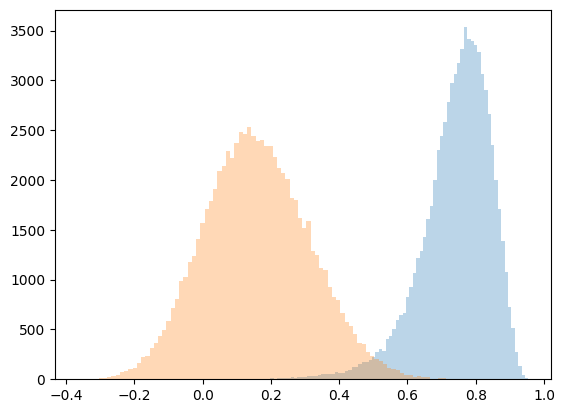

In [33]:
import matplotlib.pyplot as plt
_ = plt.hist(true_score,bins=100,alpha=0.3)
_ = plt.hist(false_score,bins=100,alpha=0.3)

## DRL-TU-MH (V22)

In [37]:
import torch.nn as nn
import torch
import torch.nn.functional as F

def init(module, weight_init, bias_init, gain=1):
    weight_init(module.weight.data, gain=gain)
    bias_init(module.bias.data)
    return module

class AddBias(nn.Module):
    def __init__(self, bias):
        super(AddBias, self).__init__()
        self._bias = nn.Parameter(bias.unsqueeze(1))

    def forward(self, x):
        bias = self._bias.t().view(1, -1)
        return x + bias

#Categorical
class FixedCategorical(torch.distributions.Categorical):
    def sample(self):
        return super().sample().unsqueeze(-1)

    def log_probs(self, actions):
        return super().log_prob(actions.squeeze(-1)).view(actions.size(0), -1).sum(-1).unsqueeze(-1)

    def entropy(self):
        p = self.probs.masked_fill(self.probs <= 0, 1)
        return -1 * p.mul(p.log()).sum(-1)

    def mode(self):
        return self.probs.argmax(dim=-1, keepdim=True)

class Categorical(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Categorical, self).__init__()

        init_ = lambda m: init(
            m, nn.init.orthogonal_, lambda x: nn.init.constant_(x, 0), gain=0.01
        )

        self.linear = init_(nn.Linear(num_inputs, num_outputs))

    def forward(self, x, mask=None):
        x = self.linear(x)
        if mask is not None:
            return FixedCategorical(logits=x + torch.log(mask))
        else:
            return FixedCategorical(logits=x)

#Normal
class FixedNormal(torch.distributions.Normal):
    def log_probs(self, actions):
        return super().log_prob(actions).sum(-1, keepdim=True)

    def entropy(self):
        return super().entropy().sum(-1)

    def mode(self):
        return self.mean

class DiagGaussian(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DiagGaussian, self).__init__()

        init_ = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.
                               constant_(x, 0))

        self.fc_mean = init_(nn.Linear(num_inputs, num_outputs))
#         desired_init_log_std = -0.693471 #exp(..) ~= 0.5
#         desired_init_log_std = -1.609437 #exp(..) ~=0.2
        desired_init_log_std = -2.302585 #exp(..) ~=0.1
        
        self.logstd = AddBias(desired_init_log_std * torch.ones(num_outputs)) #so no state-dependent sigma

    def forward(self, x, mask=None):
        action_mean = self.fc_mean(x)
#         print('action_mean',action_mean.shape,x.shape)
        zeros = torch.zeros(action_mean.size())
        if x.is_cuda:
            zeros = zeros.to('cuda:3')

        action_logstd = self.logstd(zeros)
        return FixedNormal(action_mean, action_logstd.exp())

class ActionHead(nn.Module):
    def __init__(self, input_dim, output_dim, type="categorical"):
        super(ActionHead, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.type = type
        if type == "categorical":
            self.distribution = Categorical(num_inputs=input_dim, num_outputs=output_dim)
        elif type == "normal":
            self.distribution = DiagGaussian(num_inputs=input_dim, num_outputs=output_dim)
        else:
            raise NotImplementedError

    def forward(self, input, mask):
        if self.type == "normal":
            return self.distribution(input)
        else:
            return self.distribution(input, mask)
        
class Pi_net_mh(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Pi_net_mh, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.action_heads = nn.ModuleList()
        self.action_heads.append(ActionHead(int(hidden_size/2), 2, type='categorical'))
        self.action_heads.append(ActionHead(int(hidden_size/2)+1, 1, type='normal'))
        
    def forward(self, s, deterministic=False):
        x = F.relu(self.linear1(s))
        x = F.relu(self.linear2(x))
        
        action_outputs=[]
        head_outputs=[]
        head_outputs.append(x)
        action_type_dist = self.action_heads[0](x,mask=None)
        if deterministic:
            action_type = action_type_dist.mode()
        else:
            action_type = action_type_dist.sample()
            
        head_outputs.append(action_type)
        action_outputs.append(action_type)
        head_output = torch.cat(head_outputs, dim=-1)

        head_dist = self.action_heads[1](head_output,mask=None)
        
        if deterministic:
            head_action = head_dist.mode()
        else:
            head_action = head_dist.rsample()
        
        action_outputs.append(head_action)

        joint_action_log_prob = action_type_dist.log_probs(action_type)
        entropy = action_type_dist.entropy().mean()
        
        joint_action_log_prob += head_dist.log_probs(head_action)

        entropy += head_dist.entropy().mean()
        action_outputs = torch.cat(action_outputs,dim=-1)
        return action_outputs, joint_action_log_prob, entropy
    
actor_mh = Pi_net_mh(256, 256)
checkpoint = torch.load('./DRL-TU/egs/exp/DRL-TU-MH_pretrained/model_final.pkl',map_location='cpu')
actor_mh.load_state_dict(checkpoint['pi'])
actor_mh = actor_mh.to('cuda:3')

In [ ]:
eers_v22={}
mindcts_v22={}

for tmp_scenario in tqdm(['random','1das','3das','5das','10das','1d1s','3d1s','5d1s','10d1s']):
# for tmp_scenario in tqdm(['random']):
    # 0. init
    scenario2model2day2score_v22[tmp_scenario]=defaultdict(list)
    
    # 1. Load trial trajectory and enrollment model
    f_read = open('./trials/%s/trial.pkl' %tmp_scenario, 'rb')
    trials = pickle.load(f_read)
    f_read.close()
    enrol_models={i.split()[0]:i.split()[1:] for i in open('./trials/%s/enrol_model'%tmp_scenario)}
    
    # 2. achieve enrol template
    enrol_embd_dict={}
    for tmp_model in enrol_models:
        enrol_embd=np.zeros((1,128))
        for utt in enrol_models[tmp_model]:
            enrol_embd += embds_dict[utt]

        enrol_embd_dict[tmp_model] = enrol_embd/5
    # 3. scoring
    true_score=[]
    false_score=[]
    
    if tmp_scenario in ['random']:
        for tmp_model in tqdm(trials):
            enrol_embd = enrol_embd_dict[tmp_model]
            ts=tmp_model[3:7]
            scenario2model2day2score_v22[tmp_scenario][tmp_model]=defaultdict(list)
            for utt in trials[tmp_model]:
                test_embd = embds_dict[utt]
                observation = np.concatenate((enrol_embd,test_embd),axis=1)
                observation = torch.from_numpy(observation.astype('float32'))
                observation = observation.to('cuda:3')
                action_output, _, _ = actor_mh(observation,deterministic=True)
                action_output = action_output.cpu().detach().numpy()
                action_deter, action_value = action_output[0][0], action_output[0][1]

                result = 1 - spatial.distance.cosine(enrol_embd, test_embd)
                if ts == utt[:4]:
                    true_score.append(result) 
                    scenario2model2day2score_v22[tmp_scenario][tmp_model]['true'].append(result)
                else:
                    false_score.append(result) 
                    scenario2model2day2score_v22[tmp_scenario][tmp_model]['false'].append(result)
                    
                if action_deter==1 and result>0.4:
                    enrol_embd = (1-action_value)*enrol_embd + action_value*test_embd
                    
    elif tmp_scenario in ['1das','3das','5das','10das']:
        for tmp_model in trials:
            enrol_embd = enrol_embd_dict[tmp_model]
            ts=tmp_model[3:7]
            scenario2model2day2score_v22[tmp_scenario][tmp_model]=defaultdict(list)
            for day in trials[tmp_model]:
                scenario2model2day2score_v22[tmp_scenario][tmp_model][day]=defaultdict(list)
                for utt in trials[tmp_model][day]:
                    test_embd = embds_dict[utt]
                    observation = np.concatenate((enrol_embd,test_embd),axis=1)
                    observation = torch.from_numpy(observation.astype('float32'))
                    observation = observation.to('cuda:3')
                    action_output, _, _ = actor_mh(observation,deterministic=True)
                    action_output = action_output.cpu().detach().numpy()
                    action_deter, action_value = action_output[0][0], action_output[0][1]

                    result = 1 - spatial.distance.cosine(enrol_embd, test_embd)
                    if ts == utt[:4]:
                        true_score.append(result) 
                        scenario2model2day2score_v22[tmp_scenario][tmp_model][day]['true'].append(result)
                    else:
                        false_score.append(result) 
                        scenario2model2day2score_v22[tmp_scenario][tmp_model][day]['false'].append(result)
                        
                    if action_deter==1 and result>0.4:
                        enrol_embd = (1-action_value)*enrol_embd + action_value*test_embd
                        
    elif tmp_scenario in ['1d1s','3d1s','5d1s','10d1s']:
        for tmp_round in trials:
            scenario2model2day2score_v22[tmp_scenario][tmp_round]=defaultdict(list)
            for tmp_model in trials[tmp_round]:
                enrol_embd = enrol_embd_dict[tmp_model]
                ts=tmp_model[3:7]
                scenario2model2day2score_v22[tmp_scenario][tmp_round][tmp_model]=defaultdict(list)
                for day in trials[tmp_round][tmp_model]:
                    scenario2model2day2score_v22[tmp_scenario][tmp_round][tmp_model][day]=defaultdict(list)
                    for utt in trials[tmp_round][tmp_model][day]:
                        test_embd = embds_dict[utt]
                        observation = np.concatenate((enrol_embd,test_embd),axis=1)
                        observation = torch.from_numpy(observation.astype('float32'))
                        observation = observation.to('cuda:3')
                        action_output, _, _ = actor_mh(observation,deterministic=True)
                        action_output = action_output.cpu().detach().numpy()
                        action_deter, action_value = action_output[0][0], action_output[0][1]

                        result = 1 - spatial.distance.cosine(enrol_embd, test_embd)
                        if ts == utt[:4]:
                            true_score.append(result) 
                            scenario2model2day2score_v22[tmp_scenario][tmp_round][tmp_model][day]['true'].append(result)
                        else:
                            false_score.append(result) 
                            scenario2model2day2score_v22[tmp_scenario][tmp_round][tmp_model][day]['false'].append(result)
                            
                        if action_deter==1 and result>0.4:
                            enrol_embd = (1-action_value)*enrol_embd + action_value*test_embd

    eer_v22, threshold_eer, mindct_v22, threashold_dct = compute_eer(np.array(true_score), np.array(false_score))
    eers_v22[tmp_scenario]=eer_v22
    mindcts_v22[tmp_scenario]=mindct_v22
    print('---- Scenario : %s----'%tmp_scenario)
    print('EER: %s, EER_threshold: %s \nMinDCT: %s, MinDCT_threshold: %s, '%(eer_v22*100,threshold_eer, mindct_v22, threashold_dct))
    print(len(true_score),len(false_score))
    

  4%|██▋                                                          | 76/1740 [00:34<12:25,  2.23it/s]


  9%|█████▎                                                      | 154/1740 [01:10<13:38,  1.94it/s]


 13%|████████                                                    | 232/1740 [01:45<11:45,  2.14it/s]


 18%|██████████▋                                                 | 310/1740 [02:21<09:03,  2.63it/s]


 21%|████████████▍                                               | 359/1740 [02:40<11:57,  1.93it/s]